In [69]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [13]:
scoring = {
    'pass_yd': .04,
    'pass_td': 4,
    'pass_2pt': 2,
    'pass_int': -1,
    'rush_yd': .1,
    'rush_td': 6,
    'rush_2pt': 2,
    'rec_rcpt': .5,
    'rec_yd': .1,
    'rec_td': 6,
    'rec_2pt': 2
}

In [16]:
def load_data(dir):
    positions = ["QB", "RB", "WR", "TE", "DEF"]
    dfs = {}
    for pos in positions:
        file = pos + "_projections.csv"
        if os.path.exists(os.path.join(dir, file)):
            dfs[pos] = pd.read_csv(os.path.join(dir, file))
    return dfs

cbs = load_data("data/proj_scrape/cbs")
espn = load_data("data/proj_scrape/espn")
fantasysharks = load_data("data/proj_scrape/fantasysharks")
freedraftguide = load_data("data/proj_scrape/freedraftguide")
nfl = load_data("data/proj_scrape/nfl")
numberfire = load_data("data/proj_scrape/numberfire")
# walterfootball = load_data("data/proj_scrape/walterfootball")
    

In [72]:
# Make combined dataframe

cbs


{'QB':     gp  pass_att  pass_cmp  pass_yd  pass_yd_per_game  pass_td  pass_int  \
 0   17       520       344     3972             233.6       31        17   
 1   17       538       349     3846             226.2       31        16   
 2   17       614       420     4531             266.5       32        12   
 3   17       456       299     3639             214.1       29        12   
 4   17       523       347     3974             233.8       35        11   
 ..  ..       ...       ...      ...               ...      ...       ...   
 66  17        24        17      175              10.3        1         1   
 67  17        21        12      138               8.1        1         1   
 68  17        24        15      166               9.8        1         1   
 69  15        20        13      146               9.7        1         1   
 70  17        23        15      145               8.5        1         1   
 
    pass_rate  rush_att  rush_yd  ...  fumbles_lost  fpts  fp_per_ga

In [71]:
N_BOOTSTRAPS = 10000

cols_to_sample = ['pass_yd', 'pass_td', 'pass_int', 'rush_yd', 'rush_td', 'remainder']

def calc_qb_remainder(df):
    '''takes a dataframe and subtracts the weighted sum of cols_to_sample from fpts'''
    for col in cols_to_sample:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df['remainder'] = df.apply(lambda row: row['fpts'] - sum(row[col] * scoring[col] for col in cols_to_sample if col != 'remainder'), axis=1)
    return df


qb_df_list = [cbs["QB"], espn["QB"], fantasysharks["QB"], freedraftguide["QB"], nfl["QB"], numberfire["QB"]]
qb_df_list = [calc_qb_remainder(df) for df in qb_df_list]


def bootstrap_sample(**kwargs):
    ''' '''
    samp = {}
    dataset_i = np.random.randint(0, 6, len(cols_to_sample))
    for col_i, dat_i in enumerate(dataset_i): # for each col to sample, sample a dataset
        the_dict = {
            cols_to_sample[col_i]: qb_df_list[dat_i][cols_to_sample[col_i]],
            "player": qb_df_list[dat_i]["player"] # grab the player column
        }
        samp[cols_to_sample[col_i]] = pd.DataFrame(the_dict)
    
    # merge all the dataframes on the player column
    output = samp[cols_to_sample[0]]
    output["iteration"] = kwargs["iteration"]
    
    
    for col in cols_to_sample[1:]:
        output = pd.merge(output, samp[col], on="player")
    output["fpts"] = output.apply(lambda row: sum(row[col] * scoring[col] for col in cols_to_sample if col != 'remainder'), axis=1)
    output["fpts"] += output["remainder"]
    return output
    
        

# # run bootstraps
bootstrap_results = [bootstrap_sample(iteration=i) for i in range(N_BOOTSTRAPS)]

# # combine all into one dataframe
bootstrap_df = pd.concat(bootstrap_results)

bootstrap_df.to_csv("bootstrap_results.csv")
# qb_df_list[1]
display(bootstrap_df)

,pass_yd,player,iteration,pass_td,pass_int,rush_yd,rush_td,remainder,fpts
0,3874.0,Josh Allen,0,31.0,17.2,593.0,10.000000,23.16,404.220000
1,3579.0,Jalen Hurts,0,31.0,12.9,671.0,13.000000,20.82,420.180000
2,4288.0,Patrick Mahomes,0,32.0,11.8,361.0,1.000000,29.56,359.380000
3,4012.0,Dak Prescott,0,34.0,14.8,206.0,2.000000,32.60,346.880000
4,4066.0,Joe Burrow,0,33.0,13.8,179.0,2.000000,33.22,343.960000
...,...,...,...,...,...,...,...,...,...
52,153.0,Sam Howell,9999,3.0,2.0,14.0,0.734063,9.32,31.244376
53,175.0,Jake Browning,9999,5.0,2.0,43.0,0.598299,8.50,41.389793
54,166.0,Cooper Rush,9999,0.0,0.0,0.0,0.175114,2.92,10.610685
55,146.0,Jimmy Garoppolo,9999,3.0,2.0,16.0,0.157377,2.54,20.924264


In [68]:
# group by player and average all columns except drop iteration
grouped = bootstrap_df.groupby("player").mean().reset_index()
ordered = grouped.sort_values("fpts", ascending=False)
display(ordered)


,player,pass_yd,iteration,pass_td,pass_int,rush_yd,rush_td,remainder,fpts
46,Josh Allen,4058.669255,499.500000,28.650360,14.901780,577.018241,9.898943,6.800375,385.942290
35,Jalen Hurts,3807.806364,499.500000,24.659135,12.695897,642.266843,12.096498,5.698826,380.757393
69,Patrick Mahomes,4436.920711,499.500000,32.966753,11.116572,383.906196,1.738539,11.171372,358.220494
56,Lamar Jackson,3591.126370,499.500000,24.908231,10.225184,819.579921,4.954371,4.513084,349.250097
3,Anthony Richardson,3577.651545,499.500000,20.840398,11.025915,637.853513,8.346127,2.595039,331.898887
...,...,...,...,...,...,...,...,...,...
53,Kyle Allen,0.000000,442.153846,0.000000,0.000000,-0.953846,0.000000,0.003077,-0.092308
34,Jake Haener,0.000000,492.000000,0.000000,0.050000,-3.600000,0.000000,0.000000,-0.410000
77,Spencer Rattler,0.000000,231.000000,0.000000,0.000000,8.000000,0.000000,-1.600000,-0.800000
65,Michael Pratt,0.000000,231.000000,0.000000,0.000000,8.000000,0.000000,-1.680000,-0.880000


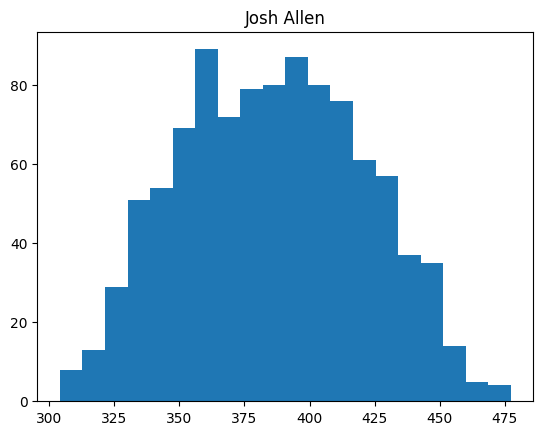

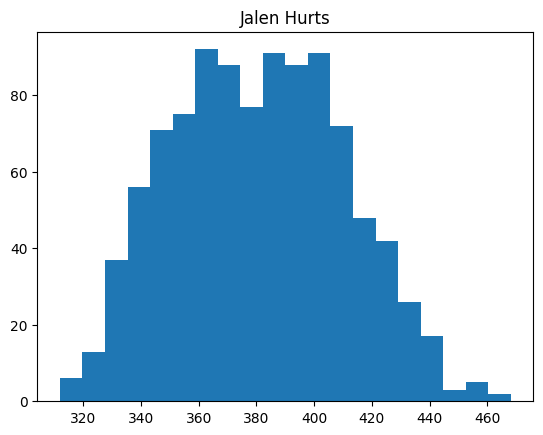

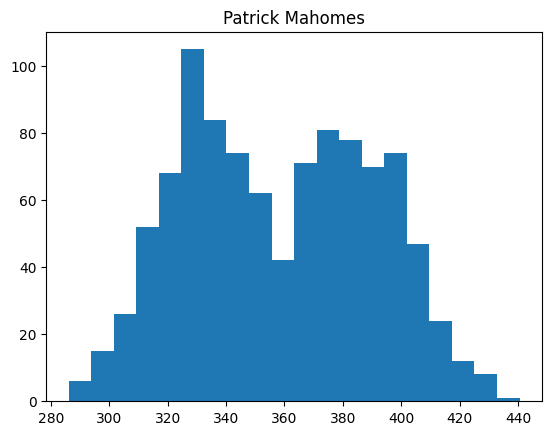

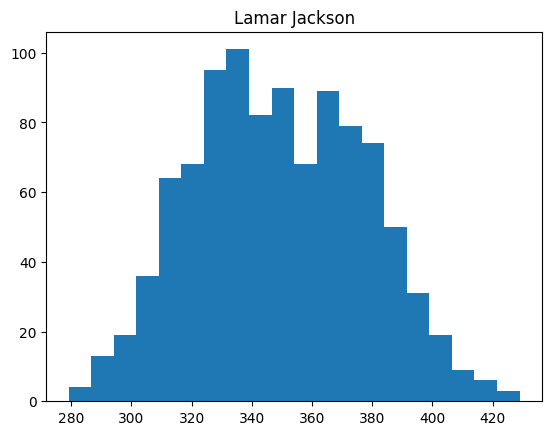

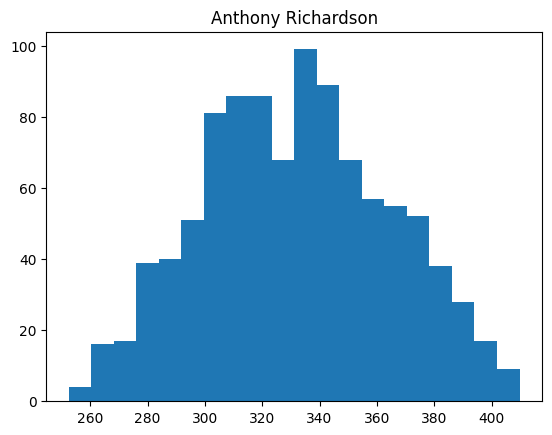

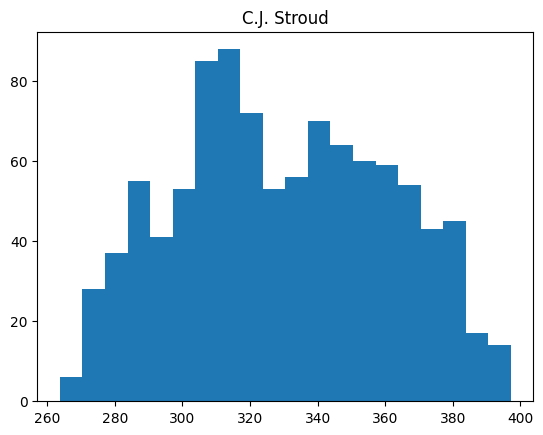

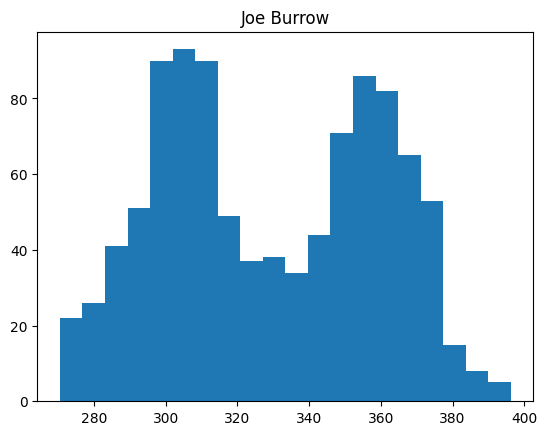

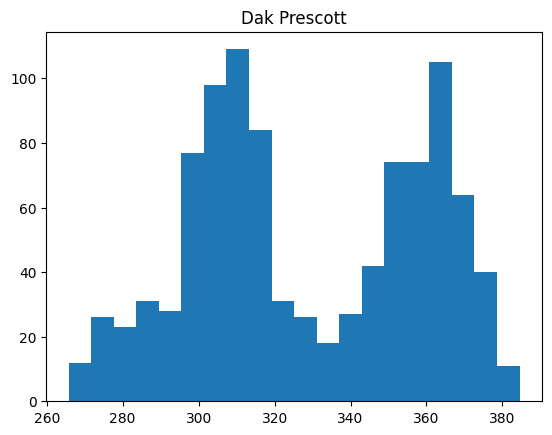

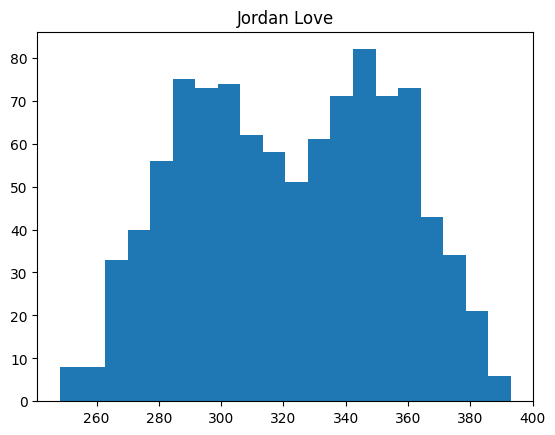

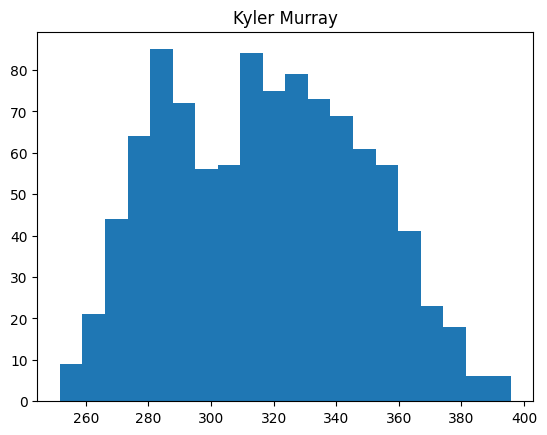

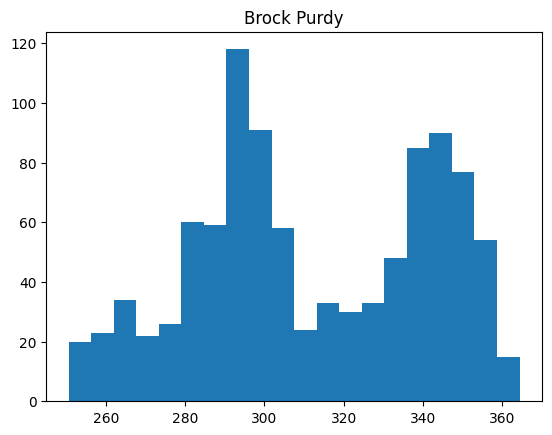

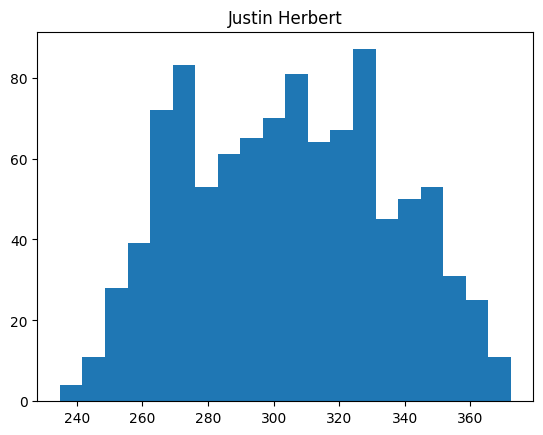

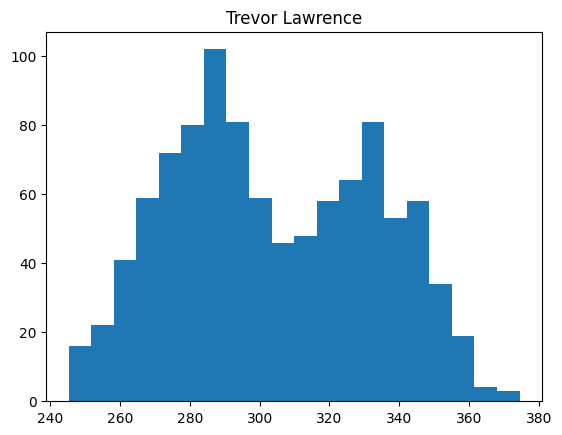

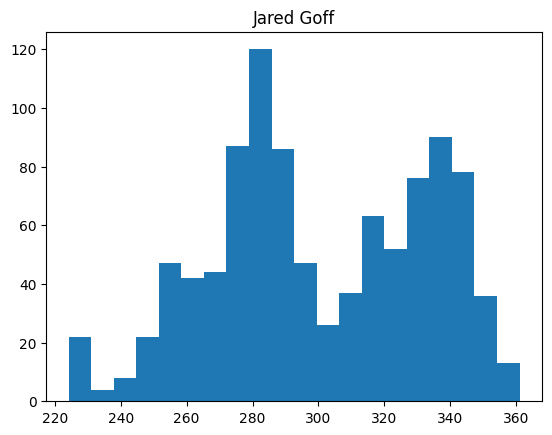

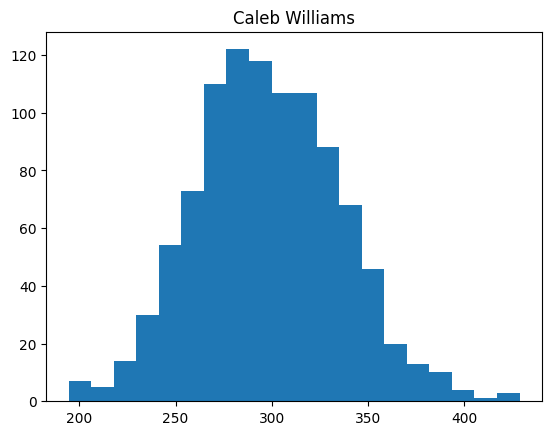

In [70]:
# make plots for the top 15 players in the ordered dataframe
for i in range(15):
    player = ordered.iloc[i]
    player_name = player["player"]
    player_data = bootstrap_df[bootstrap_df["player"] == player_name]
    plt.hist(player_data["fpts"], bins=20)
    plt.title(player_name)
    plt.show()